# 减少特征重要性低的特征生成单模型独立训练集训练程序 version 2.0   
未进行蒸馏

## 1. Import Libraries

In [1]:
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
from utils import *

## 2. Program initialization
#### <font color='Red'>注意：缺失值补插和过采样在此处设置</font>  

In [2]:
taxonomy = 'Berg'                   # choose which taxonomy:        'Berg', 'SEA_AD' or 'Mouse'
cell_subset = 'Superficial'         # choose which cells:           'All', 'Superficial' or 'Deep'
modality = 'Ephys'                  # choose which modality:        'Both', 'Ephys' or 'Morph'
rowfilte = True                     # choose if you want to row filter: True or False
scaler_method = None                # choose your data format:      'standard','minmax','robust','normalizer','quantile'
impute_method = 'knn'                # choose which imputer:         None or 'knn' or 'liner' or 'Polynomial' or 'decisiontree':
oversample_method = 'random'            # choose which oversampler:      None or 'random' or 'smote' or 'smoten' or 'smotenc' or 'borderline' or 'adasyn' or 'svmsmote' or 'kmeans'

In [3]:
# 设置缺省参数
# min_num_features = 8              # minimum number of features left to classify (e.g. 5)
# threshold_percentile = 5          # minimum percentage a feature needs to contribute to accurate prediction (e.g. 5)
min_cells_per_type = 5              # minimum cells necessary in the training data per group/label/cell-type (e.g. 5 or 10)
null_threshold = 0.2                       # row filter null value threshold
test_size =0.20                     # test size for cross validation (e.g. 0.2)
#depth_threshold = 0.575            # choose depth threshold
#index_column = 'specimen_id'       # index column name
#label_column = 'label'             # label column name
#FREM3_list = ['Exc L2-3 LINC00507 FREM3']                                    # 需区分浅层和深层FREM3细胞的列表
#superficial_t_types = ['Exc L2 LAMP5 LTK', 'Exc L2-4 LINC00507 GLP2R', 'Exc L2-3 LINC00507 FREM3 superficial']
#deep_t_types = ['Exc L2-3 LINC00507 FREM3 deep', 'Exc L3-4 RORB CARM1P1', 'Exc L3-5 RORB COL22A1']
teacher_model_path = 'models\\Teacher\\'
student_model_path = 'models\\Student\\'
#random_state = 42

## 3. Data Loading
### 3.1 读取数据文件

In [4]:
# # Define the path to the files and read in the data
meta_data_path = Path("..\data\meta_data_withVU.csv")        # read the meta data file
ephys_path = Path("..\data\ephys_data_withVU.csv")           # read the ephys data file
morph_path = Path("..\data\morph_data_withVU.csv")           # read the morph data file
# Read in the data files
meta_data = pd.read_csv(meta_data_path, index_col=0) 
ephys_data = pd.read_csv(ephys_path, index_col=0)
morph_data = pd.read_csv(morph_path, index_col=0)
print('原始数据文件：')
print('ephys_dataset:', ephys_data.shape)
print('morph_dataset:', morph_data.shape)

原始数据文件：
ephys_dataset: (522, 35)
morph_dataset: (170, 25)


### 3.2 分离标注数据和非标注数据   
统一索引列和更新L23_depth_normalized列,根据taxonomy设置标签列,根据modality设置数据集的特征列,根据cell type过滤数据集样本(行)

In [5]:
labeled_data, unlabeled_data =  load_data_l23_depth_normalized(meta_data, ephys_data, morph_data, taxonomy = taxonomy, modality = modality, cell_subset = cell_subset)
print('--- Init Setup ---')
print('Cell_subset: ',cell_subset)
print('Modality:    ', modality)
print('Taxonomy:    ', taxonomy)
print('Labeled_data:    ', labeled_data.shape)
print('Unlabeled_data:  ', unlabeled_data.shape)

--- Init Setup ---
Cell_subset:  Superficial
Modality:     Ephys
Taxonomy:     Berg
Labeled_data:     (230, 37)
Unlabeled_data:   (209, 37)


#### 3.2.1 原始的分类数和每个分类的样本数

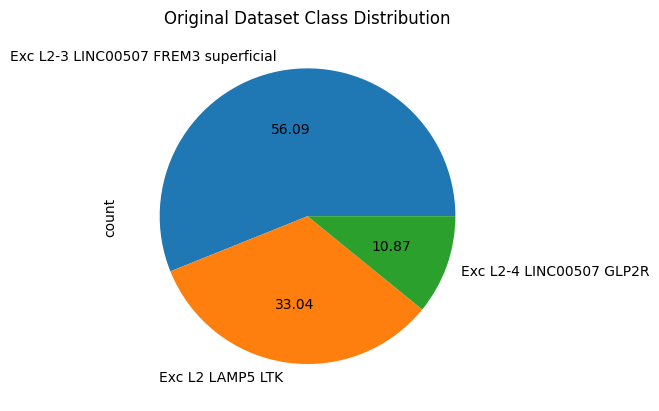

In [6]:
ax = labeled_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f')
ax.set_title("Original Dataset Class Distribution")
plt.show()

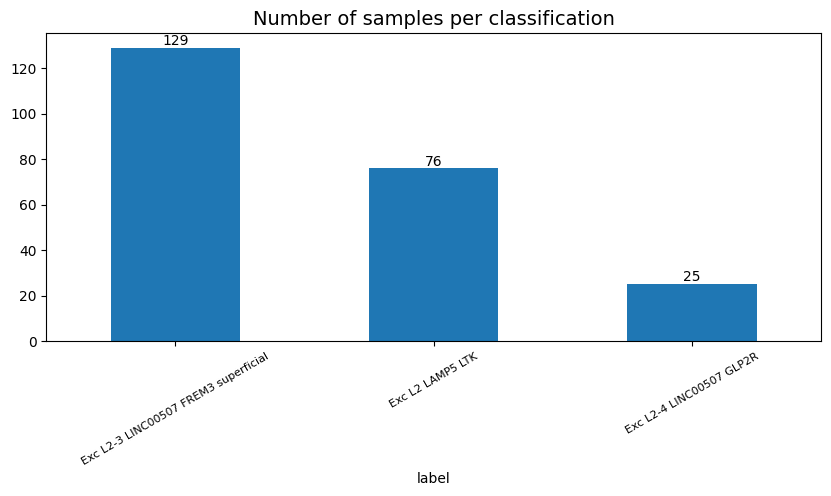

In [7]:
plt.figure(figsize=(10,4))
labeled_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

## 4 Data preprocessing 

### 4.1 行过滤 
根据每个分类最小样本数(min_cells_per_type)过滤数据集的样本(行)，根据每行空值数过滤。

In [8]:
if rowfilte:
    labeled_data = filter(labeled_data,min_cells_per_type=min_cells_per_type, threshold=null_threshold)

过滤后的分类数和每个分类的样本数绘图   
因为最少的几个分类为5、8、9，当min_cells_per_type>5时，分类会减少,这里绘图用于对比

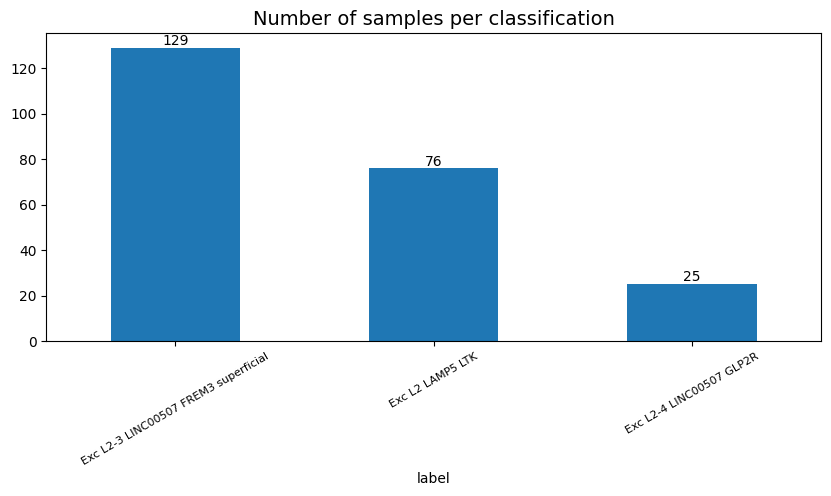

In [9]:
plt.figure(figsize=(10,4))
labeled_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

### 4.2 补插空值   
根据impute_method设置执行

#### 4.2.1 对label_data数据集补插缺失值

In [10]:
if impute_method:
    print('-------------------------------            Imputing Dataset            -------------------------------')
    print('1. Imputing Labeled Dataset')
    # 不包含标签列进行补插
    print('补插前标记数据集信息:')
    t_type_labels = labeled_data.iloc[:, -1].values
    print(labeled_data.info())
    labeled_data = impute(labeled_data.iloc[:,0:labeled_data.columns.size-1],method=impute_method)
    labeled_data[LABEL_COLUMN] = t_type_labels
    print('补插后标记数据集信息:')
    print(labeled_data.info())

-------------------------------            Imputing Dataset            -------------------------------
1. Imputing Labeled Dataset
补插前标记数据集信息:
<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 541549258 to 811939096
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      230 non-null    float64
 1   sag                   230 non-null    float64
 2   VmatSag               230 non-null    float64
 3   vmbaseM               230 non-null    float64
 4   tau                   230 non-null    float64
 5   FAP_rheobase          230 non-null    float64
 6   FAP_num_APs           230 non-null    float64
 7   TS1_rheobase          230 non-null    float64
 8   TS1_num_APs           230 non-null    float64
 9   TS2_rheobase          230 non-null    float64
 10  TS2_num_APs           230 non-null    float64
 11  TS1_adp_index         201 non-null    float64
 12  TS2_adp_index         21

#### 4.2.2 对unlabel_data数据集补插 

In [11]:
if impute_method:
    print('2. Imputing Unlabeled Dataset')
    # 对unlabel_data数据集补插 
    print('补插前未标记数据集信息:')
    print(unlabeled_data.info())
    unlabeled_data = impute(unlabeled_data.iloc[:,0:unlabeled_data.columns.size-1],method=impute_method)
    unlabeled_data[LABEL_COLUMN] = np.nan
    print('补插后未标记数据集信息:')
    print(unlabeled_data.info())

2. Imputing Unlabeled Dataset
补插前未标记数据集信息:
<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 110000001 to H23.29.252.11.91.02
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      207 non-null    float64
 1   sag                   207 non-null    float64
 2   VmatSag               207 non-null    float64
 3   vmbaseM               209 non-null    float64
 4   tau                   200 non-null    float64
 5   FAP_rheobase          209 non-null    float64
 6   FAP_num_APs           209 non-null    float64
 7   TS1_rheobase          209 non-null    float64
 8   TS1_num_APs           208 non-null    float64
 9   TS2_rheobase          208 non-null    float64
 10  TS2_num_APs           208 non-null    float64
 11  TS1_adp_index         186 non-null    float64
 12  TS2_adp_index         196 non-null    float64
 13  FAP_threshold         209 non-null    float64
 14  FAP_peak    

### 4.3 标准化   
根据scaler_method设置执行

In [12]:
# 转换为numpy数组
data_array = labeled_data.iloc[:,0:labeled_data.columns.size-1].values              # transform the data to an array

# Check if data needs to be scoring
if scaler_method:
    print('-------------------------------             Scaling Dataset            -------------------------------')
    data_array = scale(data_array, scalemethod = scaler_method)                     # apply scoring method 


cell_ids_subset = labeled_data.index                                                # extract the cell IDs of the subset
# Create a list of features
feature_list = labeled_data.iloc[:,0:labeled_data.columns.size-1].keys().values
# normalized_depths = labeled_data['L23_depth_normalized'].values                     # extract normalized depth values
t_type_labels = labeled_data.iloc[:, -1].values                                     # extract t-type labels of the data subset
t_types_updated = np.unique(t_type_labels)
print('dataset rownum:',data_array.shape[0])
print('feature num:',len(feature_list))
print('feature list:',feature_list)
print('cell type num:',len(t_types_updated))
print('cell type list:',t_types_updated)

dataset rownum: 230
feature num: 36
feature list: ['input_resistance' 'sag' 'VmatSag' 'vmbaseM' 'tau' 'FAP_rheobase'
 'FAP_num_APs' 'TS1_rheobase' 'TS1_num_APs' 'TS2_rheobase' 'TS2_num_APs'
 'TS1_adp_index' 'TS2_adp_index' 'FAP_threshold' 'FAP_peak'
 'FAP_maxupstroke' 'FAP_maxdownstroke' 'FAP_halfwidth' 'FAP_avg_upstroke'
 'FAP_avg_downstroke' 'FAP_up_down_ratio' 'TS1_threshold'
 'TS1_maxupstroke' 'TS1_maxdownstroke' 'TS1_halfwidth' 'TS1_avg_upstroke'
 'TS1_avg_downstroke' 'TS1_up_down_ratio' 'TS2_threshold' 'TS2_peak'
 'TS2_maxupstroke' 'TS2_maxdownstroke' 'TS2_avg_upstroke'
 'TS2_avg_downstroke' 'TS2_up_down_ratio' 'L23_depth_normalized']
cell type num: 3
cell type list: ['Exc L2 LAMP5 LTK' 'Exc L2-3 LINC00507 FREM3 superficial'
 'Exc L2-4 LINC00507 GLP2R']


### 4.4 训练集测试集数据拆分

In [13]:
# Split the data into a training and test dataset
X_train, X_test, y_train, y_test = train_test_split(data_array, t_type_labels, test_size=test_size, stratify=t_type_labels, random_state=RANDOM_STATE)

### 4.5 过采样解决样本不平衡问题
利用imblearn库的SMOTE、SMOTEENN、ADASYN和KMeansSMOTE算法, 解决样本不平衡问题，过采样，需要补插缺失值，否则会报错。 

In [14]:
# 组合X_train数据为dataframe，未包含label列
train_data= pd.DataFrame(data = X_train, columns = feature_list)

if oversample_method:
    # 过采样的数据集不能有空值
    # 当程序未设置插值方法,这里使用默认的knn方法,否则使用设定的插值方法
    if impute_method:
        train_data = impute(train_data, method = impute_method, random_state = RANDOM_STATE)
    else:
        train_data = impute(train_data, random_state = RANDOM_STATE)
    # 进行过采样
    X_train, y_train = oversampler(train_data.values, y_train, method = oversample_method)    
    train_data= pd.DataFrame(data = X_train, columns = feature_list)
train_data[LABEL_COLUMN] = y_train

Save Figure:Oversampled Dataset Number of samples per classification


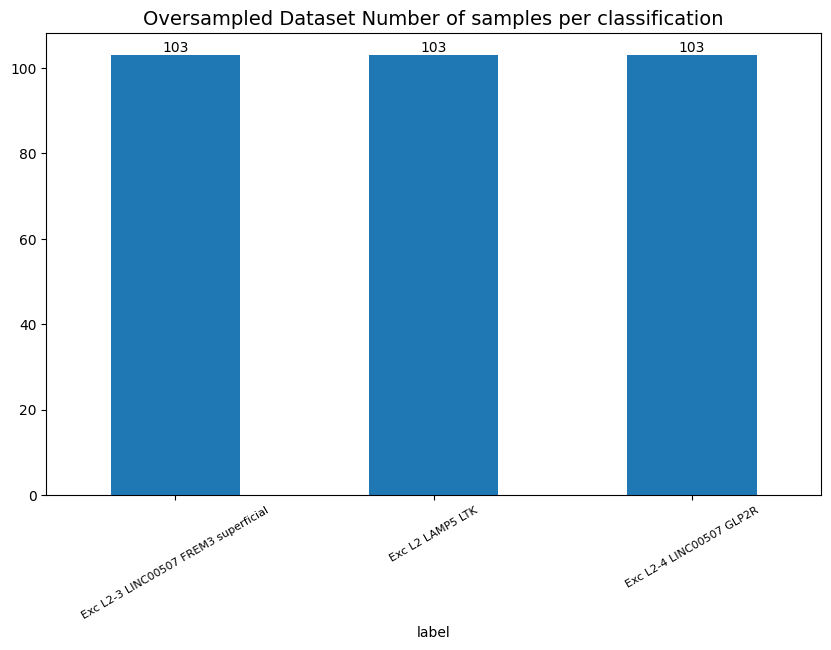

In [15]:
if oversample_method:    
    # 绘制过采样后的训练集的每分类的数量
    plt.figure(figsize=(10,6))
    train_data[LABEL_COLUMN].value_counts().plot(kind='bar')
    # 为条形图添加数值标签
    plt.bar_label(plt.gca().containers[0])
    figtitle = 'Oversampled Dataset Number of samples per classification'
    plt.title(figtitle, fontsize=14)
    plt.xticks(rotation=30,fontsize=8)
    print(f'Save Figure:{figtitle}')
    plt.show()   


Save Figure:Over-sampled Dataset Class Distribution


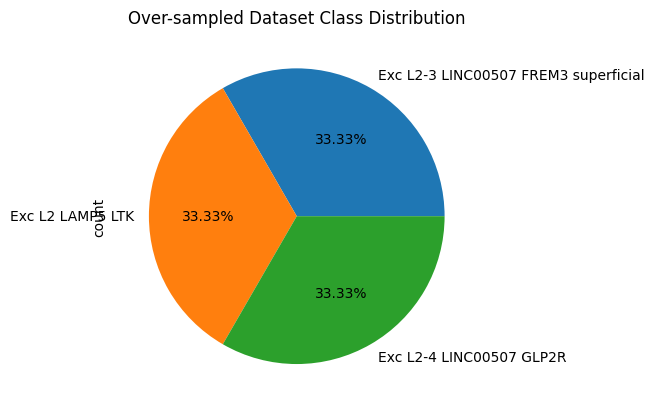

In [16]:
if oversample_method:  
    ax = train_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f%%')
    figtitle = 'Over-sampled Dataset Class Distribution'
    ax.set_title(figtitle)
    print(f'Save Figure:{figtitle}')
    plt.show()

### 4.6 生成测试数据

In [17]:
test_data_nolabel = pd.DataFrame(data = X_test, columns = feature_list)
test_data = test_data_nolabel.copy()
test_data[LABEL_COLUMN] = pd.DataFrame(y_test, columns = [LABEL_COLUMN])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      46 non-null     float64
 1   sag                   46 non-null     float64
 2   VmatSag               46 non-null     float64
 3   vmbaseM               46 non-null     float64
 4   tau                   46 non-null     float64
 5   FAP_rheobase          46 non-null     float64
 6   FAP_num_APs           46 non-null     float64
 7   TS1_rheobase          46 non-null     float64
 8   TS1_num_APs           46 non-null     float64
 9   TS2_rheobase          46 non-null     float64
 10  TS2_num_APs           46 non-null     float64
 11  TS1_adp_index         46 non-null     float64
 12  TS2_adp_index         46 non-null     float64
 13  FAP_threshold         46 non-null     float64
 14  FAP_peak              46 non-null     float64
 15  FAP_maxupstroke       46 

#### 4.6.1 test数据集按分类的分布

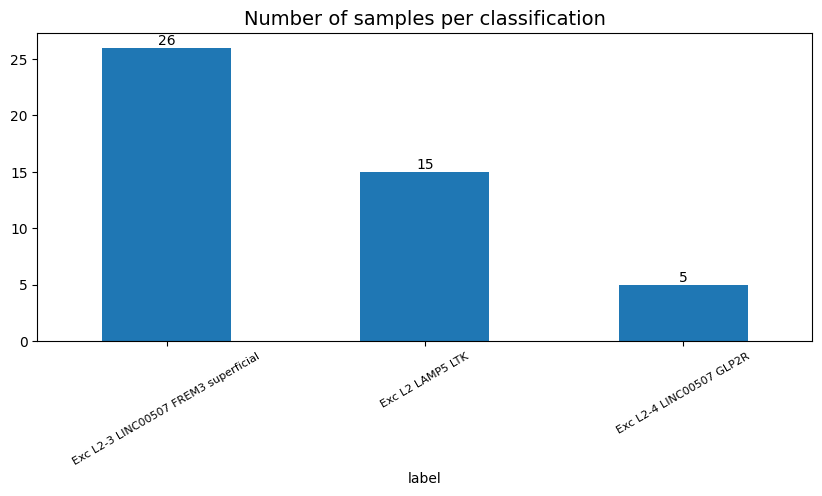

In [18]:
plt.figure(figsize=(10,4))
test_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

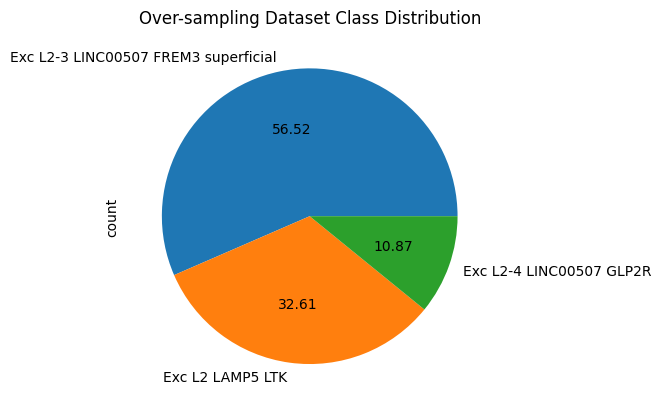

In [19]:
ax = test_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f')
ax.set_title("Over-sampling Dataset Class Distribution")
plt.show()

## 5. teacher model training   
初始话训练参数

In [20]:
#设置训练精度
presets='medium_quality'
eval_metric = 'accuracy'
verbosity = 2
time_limit = 3600
auto_stack=False
# bagging的折数,缺省好像未8
num_bag_folds=8
# stacking的级别
num_stack_levels=1
num_bag_sets=1
# n折交叉验证,设置auto_stack为True和dynamic_stacking为True
dynamic_stacking = False
# n_fold为交叉验证折数,n_repeats为交叉验证重复次数
ds_args = {
    'validation_procedure': 'cv',
    'n_folds': 5,
    'n_repeats': 1,
}
# 模型的保存路径，详细的模型命名规则见：https://auto.gluon.ai/stable/api/autogluon.tabular.models.html
save_path = teacher_model_path + presets + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S")



### 5.1 生成数据训练模型    
删除重要性低的特征生成模型独立数据集，并单独训练模型
注意：系统支持的算法类别与模型的类别不一一对应，例如KNN算法对应了两个模型:'KNeighborsUnif', 'KNeighborsDist',因此根据'KNeighborsUnif'和'KNeighborsDist'模型计算的特征重要性数据也是两份,分别生成的训练数据集也都是两份，这是利用KNN算法进行训练这两份数据就分别又得到'KNeighborsUnif', 'KNeighborsDist'两个模型和一个在这两个模型基础上的WeightedEnsemble_L2权重集成模型,共6个模型,这里的权重模型没有意义,进行了删除，因此分析时需要根据各自的数据集进行选择分析。

In [21]:
# 系统支持的算法类别和模型对比列表
models_list = ['KNN','KNN','FASTAI','GBM','GBM','GBM','RF','RF','CAT','XT','XT','XGB','NN_TORCH']
modellist = ['KNeighborsUnif', 'KNeighborsDist', 'NeuralNetFastAI', 'LightGBM', 'LightGBMXT','LightGBMLarge',
             'RandomForestGini', 'RandomForestEntr', 'CatBoost', 'ExtraTreesGini', 'ExtraTreesEntr', 
             'XGBoost', 'NeuralNetTorch']
# 读取该类别特征重要性文件，文件名为：{modality}-{cell_subset}-medium-importance.csv
featureimportance = Path(f'featureimportance\{modality}\{cell_subset}')
leaderboard = pd.DataFrame()
for i in range(len(modellist)):
    model_to_use = modellist[i]
    filename = f'{modality}-{cell_subset}-{model_to_use}-featureimportance.csv'
    importances_path = featureimportance / filename 
    importances_data = pd.read_csv(importances_path, index_col=0) 
    # 根据特征重要性条件筛选出保留的特征
    col_list = importances_data[(importances_data['importance']>0.005) | (importances_data['importance']<-0.005)].index.to_list()
    #col_list = importances_data[importances_data['importance']!=0].index.to_list()
    #重新生成训练集和测试集
    only_test_data_nolabel = test_data_nolabel[col_list]
    col_list.append(LABEL_COLUMN)
    only_train_data = train_data[col_list]
    only_test_data = test_data[col_list]

    # 开始训练
    predictor = TabularPredictor(label=LABEL_COLUMN, verbosity=verbosity,eval_metric=eval_metric, path=save_path, log_to_file=True,log_file_path='auto')
    if auto_stack and dynamic_stacking:
        predictor.fit(only_train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, num_bag_folds=num_bag_folds, 
                            num_stack_levels=num_stack_levels, num_bag_sets=num_bag_sets,dynamic_stacking=dynamic_stacking, ds_args=ds_args, included_model_types = [models_list[i]])
    elif auto_stack and not dynamic_stacking:
        predictor.fit(only_train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, num_bag_folds=num_bag_folds,
                            num_stack_levels=num_stack_levels, num_bag_sets=num_bag_sets, included_model_types = [models_list[i]])
    elif not auto_stack and dynamic_stacking:
        predictor.fit(only_train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, dynamic_stacking=dynamic_stacking, ds_args=ds_args, included_model_types = [models_list[i]])
    else:
        predictor.fit(only_train_data, presets=presets, time_limit=time_limit, included_model_types = [models_list[i]])

    # 模型评估
    models=predictor.leaderboard(only_test_data)
    # 将单模型的评估结果合并到leaderboard中
    leaderboard = pd.concat([leaderboard,models],axis=0)
# 删除权重集成模型
leaderboard = leaderboard[leaderboard['model']!='WeightedEnsemble_L2']
# 按模型排序
leaderboard.sort_values(by=['model','score_test','score_val'], ascending=False, inplace=True)
# 保存模型的结果到文件
pst = presets.split('_')[0]
cv = ''
if auto_stack and dynamic_stacking:
    validation_procedure=ds_args['validation_procedure']
    folds=ds_args['n_folds']
    repeats=ds_args['n_repeats']
    cv =f"-{validation_procedure}{folds}{repeats}"
leaderboard.to_csv(f'{modality}-{cell_subset}-{pst}{cv}-importance.csv')


Verbosity: 2 (Standard Logging)


=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       8.30 GB / 15.92 GB (52.2%)
Disk Space Avail:   307.84 GB / 931.51 GB (33.0%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "models\Teacher\medium_quality-20241105-101030"
Train Data Rows:    309
Train Data Columns: 20
Label Column:       label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	3 unique label values:  ['Exc L2-3 LINC00507 FREM3 superficial', 'Exc L2 LAMP5 LTK', 'Exc L2-4 LINC00507 GLP2R']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:      